This code extracts weather data from the NOAA ASOS system : https://www.weather.gov/asos/asostech

All the ASOS data can be accessed via ftp from their server : ftp://ftp.ncdc.noaa.gov/pub/data/noaa

Within this there are folders for each years data named 'yyyy'.

Inside each year there are gzipped files for each weather station in the network. 

The name of each file follows a pattern given by: AAAAAA-BBBBBB-YYYY.gz. For example,
723150-03812-2006 corresponds with USAF number 723150 and WBAN number 03812.

USAF and WBAN are identifiers for each station and their information is available in the **ASOS_stations.txt** file
    
YYYY stands for year

# Import statements

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()

# StationID dictionary 
I'm defining the stationID to be the string "USAF identifier-WBAN identifier"
This chunk of code generates a dict where keys are state names, values are stationID associated with that state. 

In [2]:
def generate_stationID_dict():
    '''I'm defining the stationID to be the string "USAF identifier-WBAN identifier"
      This chunk of code generates a dict where keys are state names and  
      values are stationID associated with that state. '''
    
    #filepath_stations ="/Users/NikhilStuff/Desktop/social-master/ASOS_stations.txt"
    filepath_stations = "ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.txt"
    cols_to_use = ['USAF', 'WBAN','CTRY', 'ST']
    df_stations = pd.read_fwf(filepath_stations, skiprows = 20, header =0, usecols = cols_to_use)
    df_stations_US = df_stations[df_stations.CTRY =='US'].copy()
    df_stations_US.WBAN = df_stations_US.WBAN.astype('int64')
    df_stations_US.dropna(inplace =True)
    df_stations_US = df_stations_US[df_stations_US.WBAN !=99999].copy()

    def my_func(row):
        return str(row.USAF)+ '-' + str(row.WBAN).zfill(5)
    df_stations_US['stationID'] = df_stations_US.apply(my_func, axis =1)

    states = pd.unique(df_stations_US.ST.values)
    stations_in_state = {}
    for i in range(len(states)):
        stations_in_state[states[i]] = list(df_stations_US[df_stations_US.ST == states[i]].stationID.values)
    return stations_in_state
stations_in_state = generate_stationID_dict()

In [3]:
def df_from_file(stationID,YEAR):
    ''' This takes the stationID and year and outputs a dataframe with the Temperature readings.
    Note that some tempertaure readings are missing in general.'''
    
    url_common = "ftp://ftp.ncdc.noaa.gov/pub/data/noaa/"
    url_ftp = url_common + str(YEAR)+"/"+ stationID + "-"+  str(YEAR)+".gz"
    
    WBAN = re.findall(r'(.*)-(.*)',stationID)
    WBAN = WBAN[0][1]
    
    #df = df_tmp[0].str.extractall(r'(?P<Temperature>\d\d)DEPART')
    #df = df_tmp[0].str.extractall(r'24 HR AVG TEMP \(F\):(\s)?(?P<Temperature>\d\d)')

    def extract_Temp(row):
        result = re.findall(r'24 HR AVG TEMP \(F\):(\s)?(?P<Temperature>\d\d)',row)
        if result == []: 
            result = [(np.nan,np.nan)]
        return result[-1][1]

    def extract_date(row):
        date = [np.nan,np.nan,np.nan]
        date = re.findall(WBAN + r'(\d\d\d\d)(\d\d)(\d\d)',row)
        if date != []: 
            date =  date[0][0]+ date[0][1] +  date[0][2]
        return date
    try:
        df = pd.read_csv(url_ftp, compression='gzip', header=None)
        df['TEMPERATURE'+ stationID] = df[0].apply(extract_Temp)
        df['DATE'] = df[0].apply(extract_date)
        df.dropna(inplace =True)
        df.drop(columns = [0], inplace=True)
        df['DATE'] = pd.to_datetime(df['DATE'])
        df['TEMPERATURE'+ stationID] = df['TEMPERATURE'+ stationID].astype('int64')
        df.reset_index(inplace =True)
        df.drop(columns = ['index'], inplace=True)
        return df
    except:
        print('No good')
        DATE = pd.date_range(str(YEAR)+'-01-01', str(YEAR)+'-12-31')
        df = pd.DataFrame(data =DATE, columns =['DATE'])
        return df

   

In [6]:
def all_stations_for_state_year(state,year):
    '''This function reads data from all the stations in a particular state for a particular year 
    it returns a dataframe with all the dates in that year temperatures. last column contains mean temperatures. '''
    
    df_list = []
    DATE = pd.date_range(str(year)+'-01-01', str(year)+'-12-31')
    df = pd.DataFrame(data =DATE, columns =['DATE'])
    for stID in stations_in_state[state]:
        #print(stID)
        xx = df_from_file(stID,year)
        # put code here which gets rid of leap years?
        df_list.append(xx)
    for frame in df_list:
        df =df.merge(frame, on = 'DATE', how ='left')
    df.set_index('DATE', inplace = True)
    df['MEAN_T'] = df.mean(axis =1)
    df['M/D'] = df.index.strftime('%m/%d')
    print('Finished : {}\n'.format(year))
    return df


In [7]:
def state_years(state, start_year, end_year):
    '''Returns a single df with the mean temp data for all years between start-year and end year'''
    years  = range(start_year, end_year+1,1)
    df_list = []
    for year in years:
        xx=all_stations_for_state_year(state,year)
        df_list.append(xx[['MEAN_T']])
    df = df_list[0] 
    for frame in df_list[1:]:
        df = df.append(frame)
    return df

In [8]:
df = state_years('NY', 2015,2019)

Finished : 2015

Finished : 2016

Finished : 2017

Finished : 2018

Finished : 2019



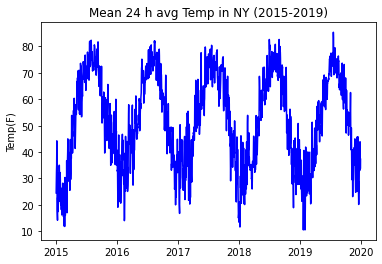

In [9]:
fig,ax =plt.subplots(1,1)

ax.plot(df.index, df['MEAN_T'],'b-')
ax.set_ylabel('Temp(F)')
ax.set_title('Mean 24 h avg Temp in NY (2015-2019)')
plt.show()